In [2]:
import numpy as np
import matplotlib.pyplot as plt

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2


from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian

from TO_sim.get_cluster import cluster_os_new2


In [22]:
seed =11
N = 5000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,5000,dt)
# K = 5.3
K = 3
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [23]:
A = (theta[-1] - theta[-1000])/(t[-1] - t[-1000])

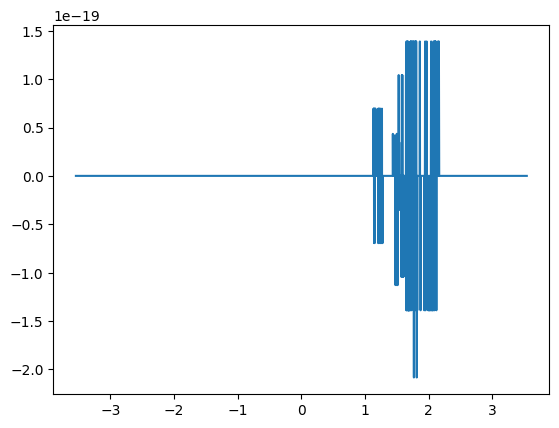

In [ ]:
plt.plot(omega,A)

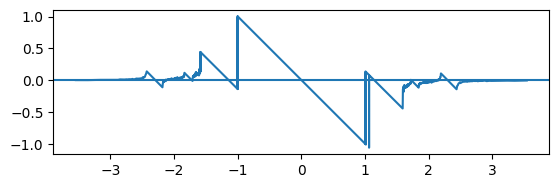

In [20]:
plt.plot(omega,A-omega)
plt.gca().set_aspect(1)
# plt.plot([-3.14,3.14],[-3.14,3.14])
plt.axhline(0)

In [ ]:
plt.scatter(theta[-1000:],dtheta[-1000:])